# Clasificador de Bandas usando Redes Neuronales

El propósito de este mini proyecto es crear una variante del código music-genre-classificator para construir una red neuronal capaz de clasificar canciones de tres grupos que, en esencia, pertenecen al mismo género: el pop-punk. Las bandas de las cuales se tomarán las muestras son Neck Deep, The Story So Far y Turnstile. Ya existen modelos que clasifican correctamente los géneros musicales, pero este proyecto va más allá, al intentar predecir casos muy particulares dentro de un mismo género. Veamos si el modelo es capaz de lograrlo.

## 1. Obtención y preparación de datos

In [1]:
pip install librosa

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ========================
# DATA AUGMENTATION HELPERS
# ========================

def add_noise(y, noise_factor=0.005):
    noise = np.random.randn(len(y))
    return y + noise_factor * noise

def change_pitch(y, sr=22050, n_steps=2):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)

def change_speed(y, speed_factor=1.0):
    return librosa.effects.time_stretch(y, speed_factor)

def shift_audio(y, shift_max=22050):
    shift = np.random.randint(-shift_max, shift_max)
    return np.roll(y, shift)


/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
def load_audio(path, sr=22050, duration=30):
    y, _ = librosa.load(path, sr=sr, duration=duration)
    if len(y) < sr * duration:
        y = np.pad(y, (0, sr * duration - len(y)))
    return y

def extract_mfcc(y, sr=22050, n_mfcc=40, fixed_length=130):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    if mfcc.shape[1] < fixed_length:
        pad_width = fixed_length - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :fixed_length]
    return mfcc


label_map = {'turnstile': 0, 'tssf': 1, 'neckdeep': 2}
base_path = '/Users/erickavendanogarcia/Desktop/ML_physics/dataset'

X, y = [], []

for band_name, label in label_map.items():
    band_path = os.path.join(base_path, band_name)
    for file in os.listdir(band_path):
        if file.endswith('.mp3'):
            file_path = os.path.join(band_path, file)
            try:
                audio = load_audio(file_path)
                mfcc = extract_mfcc(audio)
                X.append(mfcc)
                y.append(label)

                # AUGMENTED VARIANTS
                for _ in range(2):  # do augmentation twice for more samples
                    aug_audio = audio
                    if np.random.rand() < 0.5:
                        aug_audio = add_noise(aug_audio, noise_factor=np.random.uniform(0.002, 0.01))
                    if np.random.rand() < 0.5:
                        aug_audio = change_pitch(aug_audio, sr=22050, n_steps=np.random.uniform(-2, 2))
                    if np.random.rand() < 0.5:
                        speed_factor = np.random.uniform(0.9, 1.1)
                        try:
                            aug_audio = change_speed(aug_audio, speed_factor)
                        except:
                            pass
                    if np.random.rand() < 0.5:
                        aug_audio = shift_audio(aug_audio, shift_max=22050)

                    mfcc_aug = extract_mfcc(aug_audio)
                    X.append(mfcc_aug)
                    y.append(label)

            except Exception as e:
                print(f"Error con {file_path}: {e}")

X = np.array(X)
y = np.array(y)

print("Forma de X:", X.shape)
print("Forma de y:", y.shape)


Forma de X: (210, 40, 130)
Forma de y: (210,)


In [4]:
# Add channel dimension
X = X[..., np.newaxis]

# Normalización
mean = np.mean(X, axis=(1,2,3), keepdims=True)
std = np.std(X, axis=(1,2,3), keepdims=True)
X = (X - mean) / (std + 1e-6)

print("X normalizado:", X.shape)

X normalizado: (210, 40, 130, 1)


Explicación de las funciones: $\textit{def load_audio(path, sr=22050, duration=30)}$
Carga un archivo de audio desde el path usando librosa.

sr=22050: establece la frecuencia de muestreo (samples per second).

duration=30: sólo carga los primeros 30 segundos del audio.

Si el audio dura menos de 30 segundos, lo rellena con ceros (np.pad) hasta que tenga el tamaño adecuado (sr * duration).

Devuelve un arreglo y con las muestras de audio.

Función extract_mfcc(y, sr=22050, n_mfcc=40)
Calcula 40 coeficientes MFCC a partir del audio y.

mfcc tiene forma (n_mfcc, tiempo), pero el código toma el promedio a lo largo del tiempo (axis=1), para dejar un solo vector de tamaño (n_mfcc,) por canción.

Esto permite representar cada canción por un vector de características fijo, sin importar su duración real (porque ya se paddeó a 30s antes).

## 2. Datos de prueba y de entrenamiento 

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# División en entrenamiento y prueba, aleatoria en cada corrida
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)



Train: (147, 40, 130, 1) (147,)
Test: (63, 40, 130, 1) (63,)


# 3. Construcción del modelo 

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from tensorflow.keras.layers import AveragePooling2D, Conv2D, Dense, Dropout, Flatten,MaxPooling2D
from tensorflow.keras.models import Sequential

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras import regularizers

model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(40, 130, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.35),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.35),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.35),

    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.35),
    layers.Dense(3, activation='softmax')
])

model.summary()


/Library/Python/3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 128, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 31, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 31, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 29, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 14, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 14, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5376)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       688,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 781,315 (2.98 MB)

 Trainable params: 781,315 (2.98 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
optimizer = keras.optimizers.Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [9]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=10,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)


Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3052 - loss: 1.4221 - val_accuracy: 0.5079 - val_loss: 1.2976
Epoch 2/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5250 - loss: 1.2777 - val_accuracy: 0.5556 - val_loss: 1.2420
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4141 - loss: 1.2946 - val_accuracy: 0.5556 - val_loss: 1.2100
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5800 - loss: 1.1535 - val_accuracy: 0.6032 - val_loss: 1.1726
Epoch 5/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6980 - loss: 1.0545 - val_accuracy: 0.5873 - val_loss: 1.1191
Epoch 6/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5763 - loss: 1.0861 - val_accuracy: 0.6508 - val_loss: 1.0857
Epoch 7/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6898 - loss: 0.9464 - val_accuracy: 0.6032 - val_loss: 1.0525
Epoch 8/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6199 - loss: 0.9674 - val_accuracy: 0.6667 - v

## 4. Graficando los datos de validación y de perdida

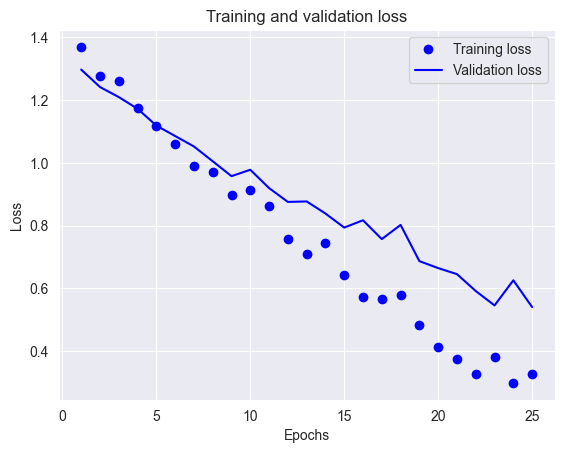

In [10]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

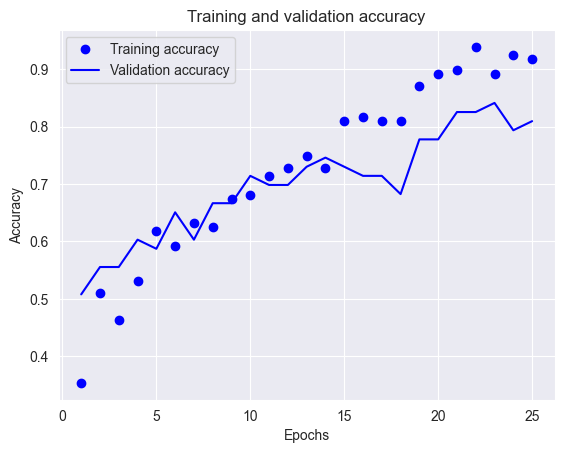

In [11]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [12]:
y_test

array([1, 2, 0, 2, 1, 2, 0, 1, 2, 2, 1, 0, 0, 1, 2, 2, 0, 2, 2, 1, 1, 0,
       2, 2, 0, 0, 1, 2, 0, 0, 2, 0, 1, 2, 2, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 2, 1, 0, 0, 0, 0, 2, 1, 1, 2, 1, 1, 1])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


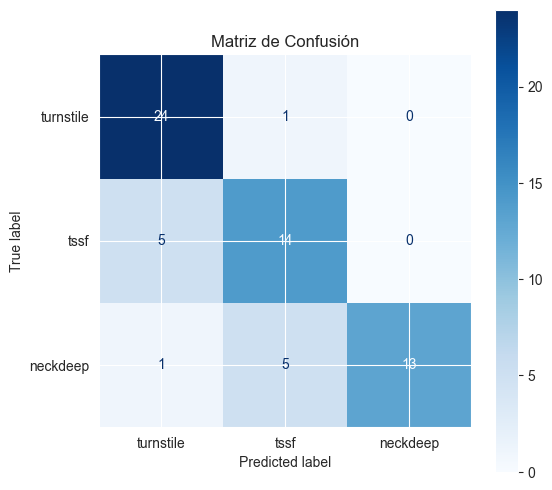

In [13]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(y_test, y_pred)
labels = ['turnstile', 'tssf', 'neckdeep']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Matriz de Confusión")
plt.show()


In [14]:
model.evaluate(X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8105 - loss: 0.5221


[0.5405100584030151, 0.8095238208770752]

# 5. Predicción  de una nueva canción


In [18]:
# Chequemos si el modelo es capaz de predecir si la canción nueva de Neck Deep en efecto es de Neck Deep

new_song_path = '/Users/erickavendanogarcia/Downloads/ys.mp3'
audio_new = load_audio(new_song_path)
mfcc_new = extract_mfcc(audio_new)
mfcc_new = (mfcc_new - np.mean(mfcc_new)) / (np.std(mfcc_new) + 1e-6)
x_new = mfcc_new[np.newaxis, ..., np.newaxis]

prediction = model.predict(x_new)
predicted_class = np.argmax(prediction)

inv_label_map = {v: k for k, v in label_map.items()}
print(f"La canción fue clasificada como: {inv_label_map[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
La canción fue clasificada como: turnstile


In [19]:
prediction

array([[0.9764347 , 0.00186693, 0.02169833]], dtype=float32)

#Visualización de un MFCC


file_path = '/Users/erickavendanogarcia/Desktop/ML_physics/dataset/turnstile/turnstile_Icare.mp3'

# Cargar el audio
y, sr = librosa.load(file_path, sr=22050, duration=30)

# Extraer MFCC (sin promediar)
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

# Mostrar espectrograma MFCC
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC - Turnstile')
plt.tight_layout()
plt.show()

# Mostrar vector promedio
mfcc_mean = np.mean(mfcc, axis=1)
plt.figure(figsize=(8, 4))
plt.bar(range(len(mfcc_mean)), mfcc_mean)
plt.xlabel('Índice del coeficiente MFCC')
plt.ylabel('Valor promedio')
plt.title('MFCC Promediado - Turnstile')
plt.show()